# Process the deep mutational scanning data

The data come from the following papers from Yunlong Cao's group:

 - [Imprinted SARS-CoV-2 humoral immunity induces convergent Omicron RBD evolution (2022)](https://www.nature.com/articles/s41586-022-05644-7)
 
 - [Repeated Omicron infection alleviates SARS-CoV-2 immune imprinting (2024)](https://www.nature.com/articles/s41586-023-06753-7)

 - [Evolving antibody response to SARS-CoV-2 antigenic shift from XBB to JN.1](https://www.nature.com/articles/s41586-024-08315-x)

In [1]:
import math
import os

import matplotlib.pyplot as plt

import numpy

import pandas as pd

import yaml

with open("config.yaml") as f:
    config = yaml.safe_load(f)
    
antibody_reweighting = config["antibody_reweighting"]

## Process data from [Evolving antibody response to SARS-CoV-2 antigenic shift from XBB to JN.1](https://www.nature.com/articles/s41586-024-08315-x)

In [2]:
# read the antibody data
evolving_2024_info = (
    pd.read_csv(
        "Cao_data/JN1-evolving-antibody-response/data/_Table_S2.csv",
    )
    .assign(study="evolving_2024")
)

assert len(evolving_2024_info) == evolving_2024_info["antibody"].nunique()

print(f"{evolving_2024_info['antibody'].nunique()=}")

evolving_2024_info['antibody'].nunique()=2915


In [3]:
# get the antibody sources
evolving_2024_source = (
    evolving_2024_info
    [["antibody", "source", "study"]]
)

print("Number of antibodies from each source:")
display(
    evolving_2024_source
    .groupby(["study", "source"])
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)

Number of antibodies from each source:


n_antibodies
study         source                                      
evolving_2024 BA.5 BTI + XBB infection                 383
              BA.5 + XBB infection                     314
              XBB BTI                                  303
              XBB infection                            301
              BA.5 BTI + JN.1 infection                300
              BA.5 BTI + HK.3 infection                300
              BA.5 + JN.1 infection                    200
              BA.1 BTI + BA.5/BF.7 infection           162
              BA.2 BTI + BA.5/BF.7 infection           135
              BA.2 + BA.5/BF.7 infection               109
              BA.1 + BA.5/BF.7 infection                97
              BA.5 BTI                                  78
              BA.2 BTI                                  57
              BF.7 BTI                                  53
              BA.1 BTI                                  52
              long-term BA.5 BTI                        26
              long-term BA.1 BTI                        16
              WT convalescents                          11
              SARS exposure                              7
              long-term BA.5 infection                   7
              N.D.                                       2
              SARS                                       1
              WT-phage display                           1

In [4]:
# get the IC50s

evolving_2024_viruses = [
    "D614G",
    "BA.1",
    "BA.2",
    "BA.5", 
    "XBB.1.5",
    "HK.3.1",
    "BA.2.86",
    "JN.1",
    "JN.1+F456L",
    "KP.2",
    "JN.1+F456L+A475V",
    "KP.3",
    "KP.3+A475V",
]
assert set(evolving_2024_viruses).issubset(evolving_2024_info.columns)

evolving_2024_ic50s = (
    evolving_2024_info
    .melt(
        id_vars=["study", "antibody"],
        value_vars=evolving_2024_viruses,
        var_name="virus",
        value_name="IC50",
    )
    .query("IC50 != 'N.D.'")  # IC50 not measured
    # 10 is max value, taken to mean no neutralization
    .assign(
        IC50=lambda x: x["IC50"].map(lambda ic50: 10 if ic50 == ">10" else min(10, float(ic50)))
    )
)

print("\nNumber of IC50s per antibody:")
display(
    evolving_2024_ic50s
    .groupby("antibody", as_index=False)
    .aggregate(viruses_w_IC50s=pd.NamedAgg("virus", lambda s: "; ".join(s)))
    .groupby("viruses_w_IC50s")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)

print("IC50s at different quantiles:")
evolving_2024_ic50s["IC50"].quantile([0, 0.01, 0.1, 0.25, 0.5, 0.7, 0.9, 0.99, 1])


Number of IC50s per antibody:


,n_antibodies
viruses_w_IC50s,
D614G; BA.1; BA.2; BA.5; XBB.1.5; HK.3.1; BA.2.86; JN.1; JN.1+F456L; KP.2; JN.1+F456L+A475V; KP.3; KP.3+A475V,2066
D614G; BA.1; BA.2; BA.5; XBB.1.5; HK.3.1; BA.2.86; JN.1; KP.3,366
D614G; BA.1; BA.2; BA.5; XBB.1.5,197
D614G; BA.1; BA.2; BA.5; XBB.1.5; HK.3.1; BA.2.86; JN.1; JN.1+F456L; KP.2; JN.1+F456L+A475V; KP.3,132
D614G; BA.1; BA.2; BA.5; XBB.1.5; HK.3.1; BA.2.86; JN.1; JN.1+F456L; JN.1+F456L+A475V; KP.3,46
D614G; BA.1; BA.2; BA.5; XBB.1.5; HK.3.1; BA.2.86; JN.1; JN.1+F456L; JN.1+F456L+A475V; KP.3; KP.3+A475V,45
D614G; BA.1; BA.2; BA.5; XBB.1.5; HK.3.1; BA.2.86; JN.1; KP.2; KP.3,30
D614G; BA.1; BA.2; BA.5; XBB.1.5; HK.3.1; BA.2.86; JN.1; JN.1+F456L; KP.2; JN.1+F456L+A475V,6
D614G; BA.1; BA.2; BA.5; XBB.1.5; HK.3.1; BA.2.86,6


IC50s at different quantiles:


0.00    2.119000e-14
0.01    5.000000e-04
0.10    3.027000e-03
0.25    1.940000e-02
0.50    1.478600e+00
0.70    1.000000e+01
0.90    1.000000e+01
0.99    1.000000e+01
1.00    1.000000e+01
Name: IC50, dtype: float64

Now read the actual escape data:

In [5]:
evolving_2024_escape = (
    pd.read_csv("Cao_data/JN1-evolving-antibody-response/data/DMS/antibody/dms_antibodies_XBB15_JN1_agg.csv")
    .groupby(["antibody", "site"], as_index=False)
    .aggregate(escape=pd.NamedAgg("mut_escape", "sum"))
    .assign(study="evolving_2024")
)

# The antibodies are named "BD57-<xxx>" in the antibody info, and
# "GC<xxx>" in the escape data; harmonize
assert not evolving_2024_ic50s["antibody"].str.startswith("GC").any()
evolving_2024_escape = evolving_2024_escape.assign(
    antibody=lambda x: x["antibody"].map(
        lambda a: "BD57-" + a[2:] if a.startswith("GC") else a
    )
)

evolving_2024_abs = set(evolving_2024_ic50s["antibody"]).intersection(evolving_2024_escape["antibody"])
n_missing_dms = len(set(evolving_2024_ic50s["antibody"]) - set(evolving_2024_escape["antibody"]))
print(f"{len(evolving_2024_abs)=} have antibody info and DMS, {n_missing_dms=} are missing DMS but have antibody info")

# only keep escape for antibodies with IC50s
evolving_2024_escape = evolving_2024_escape.query("antibody in @evolving_2024_abs")

len(evolving_2024_abs)=2581 have antibody info and DMS, n_missing_dms=332 are missing DMS but have antibody info


## Process data from [Repeated Omicron infection alleviates SARS-CoV-2 immune imprinting (2024)](https://www.nature.com/articles/s41586-023-06753-7)

In [6]:
# read the data
repeated_2024_info = (
    pd.read_csv("Cao_data/SARS-CoV-2-reinfection-DMS/antibody_info.csv")
    .rename(columns={"Unnamed: 0": "antibody"})
).assign(study="repeated_2024")

assert len(repeated_2024_info) == repeated_2024_info["antibody"].nunique()

In [7]:
# get the antibody sources
repeated_2024_source = (
    repeated_2024_info
    [["antibody", "source", "study"]]
    .query("source != 'WT mouse'")  # do not keep mouse antibodies
)

print("Number of antibodies from each source:")
display(
    repeated_2024_source
    .groupby(["study", "source"])
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)

Number of antibodies from each source:


n_antibodies
study         source                                      
repeated_2024 BA.5 convalescents                       445
              BA.1 convalescents reinfection           284
              BF.7 convalescents                       243
              BA.2 convalescents reinfection           232
              BA.2 convalescents                        53
              long-term BA.1 convalescents              38
              BA.1 convalescents                        36
              WT convalescents                          12
              SARS convalescents                         5

In [8]:
# get the IC50s
repeated_2024_ic50s = (
    repeated_2024_info
    .melt(
        id_vars=["study", "antibody"],
        value_vars=[c for c in repeated_2024_info if c.endswith("_IC50")],
        var_name="virus",
        value_name="IC50",
    )
    .query("IC50.notnull()")  # no data, 10 means non-neutralizing
    .assign(
        virus=lambda x: x["virus"].str.replace("_IC50", "").map({
            "D614G": "D614G",
            "BA1": "BA.1",
            "BA2": "BA.2",
            "BA3": "BA.3",
            "SARS": "SARS",
            "BA1_1": "BA.1.1",
            "BA2_12_1": "BA.2.12.1",
            "BA2_75": "BA.2.75",
            "BA5": "BA.5",
            "BF7": "BF.7",
            "BA2_13": "BA.2.13",
            "BQ1_1": "BQ.1.1",
            "XBB": "XBB",
            "XBB1_5": "XBB.1.5",
            "XBB1_5_10": "XBB.1.5.10",
        }),
    )
)

print("\nNumber of IC50s per antibody:")
display(
    repeated_2024_ic50s
    .groupby("antibody", as_index=False)
    .aggregate(viruses_w_IC50s=pd.NamedAgg("virus", lambda s: "; ".join(s)))
    .groupby("viruses_w_IC50s")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)


Number of IC50s per antibody:


,n_antibodies
viruses_w_IC50s,
D614G; BA.1; BA.2; SARS; BA.2.75; BA.5; BF.7; BQ.1.1; XBB; XBB.1.5; XBB.1.5.10,428
D614G; BA.1; BA.2; SARS; BA.2.75; BA.5; BF.7; BQ.1.1; XBB; XBB.1.5,181
D614G; BA.1; BA.2; BA.3; SARS; BA.1.1; BA.2.12.1; BA.2.75; BA.5; BA.2.13; BQ.1.1; XBB; XBB.1.5; XBB.1.5.10,137
D614G; BA.1; BA.2; SARS; BA.2.75; BA.5; BQ.1.1; XBB; XBB.1.5; XBB.1.5.10,130
D614G; BA.1; BA.2; BA.2.75; BA.5; BF.7; BQ.1.1; XBB; XBB.1.5; XBB.1.5.10,129
D614G; BA.1; BA.2; SARS; BA.2.75; BA.5; BQ.1.1; XBB; XBB.1.5,92
D614G; BA.1; BA.2; BA.2.75; BA.5; BQ.1.1; XBB; XBB.1.5,48
D614G; SARS; BA.5; BQ.1.1; XBB; XBB.1.5; XBB.1.5.10,42
D614G; BA.1; BA.2; BA.2.75; BA.5; BQ.1.1; XBB; XBB.1.5; XBB.1.5.10,34


In [9]:
# get the binding reactivities
repeated_2024_binding = (
    repeated_2024_info
    .query("paper_reactivity != '--'")
    .assign(
        binds=lambda x: x["paper_reactivity"].map(
            {
                "WT": ["Wuhan-Hu-1"],
                "cross": ["Wuhan-Hu-1", "Omicron BA.2/BA.5"],
                "specific": ["Omicron BA.2/BA.5"],
            }
        )
    )
    [["study", "antibody", "binds"]]
    .explode("binds")
)

print("\nBinding targets per antibody:")
display(
    repeated_2024_binding
    .groupby("antibody", as_index=False)
    .aggregate(binds=pd.NamedAgg("binds", lambda s: "; ".join(s)))
    .groupby("binds")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)


Binding targets per antibody:


,n_antibodies
binds,
Wuhan-Hu-1; Omicron BA.2/BA.5,768
Omicron BA.2/BA.5,562
Wuhan-Hu-1,19


Now read the actual escape data:

In [10]:
repeated_2024_escape = (
    pd.read_csv("Cao_data/SARS-CoV-2-reinfection-DMS/antibody_dms_merge_clean.csv.gz")
    .groupby(["antibody", "site"], as_index=False)
    .aggregate(escape=pd.NamedAgg("mut_escape", "sum"))
    .assign(study="repeated_2024")
)

repeated_2024_escape.sort_values("escape")

,antibody,site,escape,study
45314,GC1852,390,5.628970e-08,repeated_2024
45311,GC1852,371,6.030392e-08,repeated_2024
45312,GC1852,373,6.448414e-08,repeated_2024
45323,GC1852,514,7.860392e-08,repeated_2024
45313,GC1852,377,9.080642e-08,repeated_2024
...,...,...,...,...
7512,GC0281,444,1.611308e+01,repeated_2024
4258,GC0177,346,1.637373e+01,repeated_2024
19760,GC0832,444,1.644617e+01,repeated_2024
4775,GC0191,444,1.648478e+01,repeated_2024


Now get the antibody re-weightings.
These are based on the re-weightings described in [Repeated Omicron infection alleviates SARS-CoV-2 immune imprinting (2023)](https://www.biorxiv.org/content/10.1101/2023.05.01.538516v2).
We want to re-weight the cross-reactive antibodies by an amount $w$ so that the desired cross reactive fraction $x$ satisfies $x = \frac{w N_c}{w N_c + N_s}$ where $w$ is the re-weighting assigned to the cross-reactive antibodies, $N_c$ is the number of cross-reactive antibodies, and $N_s$ is the number of specific antibodies.
This can be achieved by assigning $w = \frac{x N_s}{N_c + x N_c}$; we then adjust the weights again so the mean weight over all antibodies for the source equals the number of antibodies.

In [11]:
repeated_2024_desired_reweighting = (
    pd.Series(antibody_reweighting["repeated_2024"]["cross_reactive_weights"])
    .rename_axis("source")
    .rename("desired_cross_reactive_frac")
    .reset_index()
)
assert set(repeated_2024_desired_reweighting["source"]).issubset(repeated_2024_source["source"])
print(f"Using the following reweightings:\n{repeated_2024_desired_reweighting}")

repeated_2024_reweighting = (
    repeated_2024_binding
    .groupby("antibody", as_index=False)
    .aggregate(n_binds=pd.NamedAgg("binds", "nunique"))
    .assign(cross_reactive=lambda x: x["n_binds"] == 2)
    .merge(repeated_2024_source, on="antibody", validate="one_to_one")
    .merge(repeated_2024_desired_reweighting, on="source", validate="many_to_one")
    .assign(
        N_c=lambda x: x.groupby("source")["cross_reactive"].transform("sum"),
        N=lambda x: x.groupby("source")["antibody"].transform("count"),
        N_s=lambda x: x["N"] - x["N_c"],
        cross_reactive_frac=lambda x: x["N_c"] / x["N"],
        reweight=lambda x: numpy.where(
            x["cross_reactive"],
            (
                x["desired_cross_reactive_frac"] * x["N_s"]
                / (x["N_c"] * (1 - x["desired_cross_reactive_frac"]))
            ),
            1,
        ),
    )
    .assign(
        reweight=lambda x: (
            x["reweight"] / x.groupby("source")["reweight"].transform("mean")
        ),
    )
)

print("\nConfirm re-weighting worked:")
display(
    repeated_2024_reweighting
    .assign(cross_reactive_reweight=lambda x: x["cross_reactive"] * x["reweight"])
    .groupby(["source", "desired_cross_reactive_frac", "cross_reactive_frac"], as_index=False)
    .aggregate(
        reweighted_cross_reactive_sum=pd.NamedAgg("cross_reactive_reweight", "sum"),
        reweighted_sum=pd.NamedAgg("reweight", "sum"),
    )
    .assign(
        cross_reactive_reweight_frac=lambda x: x["reweighted_cross_reactive_sum"] / x["reweighted_sum"],
    )
    .drop(columns=["reweighted_cross_reactive_sum", "reweighted_sum"])
    .merge(
        repeated_2024_reweighting
        .groupby("source", as_index=False)
        .aggregate(
            n_antibodies=pd.NamedAgg("antibody", "nunique"),
            summed_reweights=pd.NamedAgg("reweight", "sum"),
        )
    )
)

print("\nHere are the re-weightings:")
display(
    repeated_2024_reweighting
    [["study", "source", "cross_reactive", "reweight"]]
    .drop_duplicates()
    .sort_values(["source", "cross_reactive"])
    .reset_index(drop=True)
)

# get the reweightings
repeated_2024_reweighting = (
    repeated_2024_reweighting
    [["antibody", "study", "reweight"]]
)

repeated_2024_reweighting

Using the following reweightings:
                           source  desired_cross_reactive_frac
0              BA.5 convalescents                         0.89
1              BF.7 convalescents                         0.89
2  BA.1 convalescents reinfection                         0.51
3  BA.2 convalescents reinfection                         0.51

Confirm re-weighting worked:


,source,desired_cross_reactive_frac,cross_reactive_frac,cross_reactive_reweight_frac,n_antibodies,summed_reweights
0,BA.1 convalescents reinfection,0.51,0.345070,0.51,284,284.0
1,BA.2 convalescents reinfection,0.51,0.439655,0.51,232,232.0
2,BA.5 convalescents,0.89,0.713964,0.89,444,444.0
3,BF.7 convalescents,0.89,0.728395,0.89,243,243.0



Here are the re-weightings:


,study,source,cross_reactive,reweight
0,repeated_2024,BA.1 convalescents reinfection,False,0.748172
1,repeated_2024,BA.1 convalescents reinfection,True,1.477959
2,repeated_2024,BA.2 convalescents reinfection,False,0.874462
3,repeated_2024,BA.2 convalescents reinfection,True,1.160000
4,repeated_2024,BA.5 convalescents,False,0.384567
5,repeated_2024,BA.5 convalescents,True,1.246562
6,repeated_2024,BF.7 convalescents,False,0.405000
7,repeated_2024,BF.7 convalescents,True,1.221864


,antibody,study,reweight
0,CP0590,repeated_2024,1.246562
1,GC0101,repeated_2024,1.246562
2,GC0102,repeated_2024,1.246562
3,GC0103,repeated_2024,1.246562
4,GC0104,repeated_2024,1.246562
...,...,...,...
1198,GC2054,repeated_2024,1.477959
1199,GC2056,repeated_2024,1.477959
1200,GC2057,repeated_2024,1.477959
1201,GC2058,repeated_2024,0.874462


## Process data from [Imprinted SARS-CoV-2 humoral immunity induces convergent Omicron RBD evolution (2022)](https://www.nature.com/articles/s41586-022-05644-7)

In [12]:
# read the data, which is in multiple sheets
imprinted_2022_raw_info = pd.read_excel(
    "Cao_data/convergent_RBD_evolution/antibody_info.xlsx",
    header=1,
    sheet_name=None,
    usecols=lambda c: not c.startswith("Unnamed"),
)

common_cols = None

for sheetname, sheet in imprinted_2022_raw_info.items():
    columns = sheet.columns.tolist()
    if common_cols is None:
        common_cols = columns
    else:
        common_cols = [
            c for c in columns if c in set(common_cols).intersection(columns)
        ]

imprinted_2022_info = pd.concat(
    [
        sheet[common_cols].assign(sheet_name=sheet_name)
        for sheet_name, sheet in imprinted_2022_raw_info.items()
    ],
    ignore_index=True,
).rename(columns={"Antibody  Name": "antibody"}).assign(study="imprinted_2022")

assert len(imprinted_2022_info) == imprinted_2022_info["antibody"].nunique()

In [13]:
# get the antibody sources
imprinted_2022_source = (
    imprinted_2022_info
    [["antibody", "source", "study"]]
    .query("source != 'WT-engineered'")
)

display(
    imprinted_2022_source
    .groupby(["study", "source"])
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
)

n_antibodies
study          source                          
imprinted_2022 BA.1 convalescents           752
               BA.2 convalescents           751
               BA.5 convalescents           269
               SARS convalescents           881
               WT convalescents             438
               WT vaccinees                 240

In [14]:
# get the IC50s
imprinted_2022_ic50s = (
    imprinted_2022_info
    .melt(
        id_vars=["study", "antibody"],
        value_vars=["D614G", "BA.1", "BA.2", "BA.5", "BA.2.75", "BQ.1.1", "XBB"],
        var_name="virus",
        value_name="IC50",
    )
    # values of >10 to 10
    .query("IC50 != '--'")
    .assign(IC50=lambda x: x["IC50"].map(lambda ic50: 10 if ic50 == ">10" else float(ic50)))
)

print("\nNumber of IC50s per antibody:")
display(
    imprinted_2022_ic50s
    .groupby("antibody", as_index=False)
    .aggregate(viruses_w_IC50s=pd.NamedAgg("virus", lambda s: "; ".join(s)))
    .groupby("viruses_w_IC50s")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)


Number of IC50s per antibody:


,n_antibodies
viruses_w_IC50s,
D614G; BA.1; BA.2; BA.5; BA.2.75; BQ.1.1; XBB,3309
D614G; BA.1; BA.2; BA.5; BA.2.75,13
D614G; BA.1; BA.2; BA.5; BA.2.75; BQ.1.1,3
D614G; BA.1; BA.2; BA.5; BA.2.75; XBB,3
BQ.1.1; XBB,2
BA.1; BQ.1.1; XBB,1
BA.1; BA.2; BA.5; BA.2.75; BQ.1.1; XBB,1
D614G; BQ.1.1; XBB,1


Now read the actual escape data:

In [15]:
imprinted_2022_escape = (
    pd.read_csv("Cao_data/convergent_RBD_evolution/use_res_clean.csv")
    .groupby(["antibody", "site"], as_index=False)
    .aggregate(escape=pd.NamedAgg("mut_escape", "sum"))
    .assign(study="imprinted_2022")
)

imprinted_2022_escape

,antibody,site,escape,study
0,1-57,338,0.521154,imprinted_2022
1,1-57,359,0.140217,imprinted_2022
2,1-57,370,0.285110,imprinted_2022
3,1-57,394,0.112732,imprinted_2022
4,1-57,396,0.194379,imprinted_2022
...,...,...,...,...
63387,XGv-422,465,0.769640,imprinted_2022
63388,XGv-422,466,0.886558,imprinted_2022
63389,XGv-422,468,0.313522,imprinted_2022
63390,XGv-422,484,0.165163,imprinted_2022


## Aggregate the antibody information from the different studies

First, read the information on duplicated antibodies to get duplicate names:

In [16]:
antibody_renaming = (
    pd.read_excel("Cao_data/all-repo-duplicates.xlsx")
    .set_index("Antibody  Name")
    ["BD equivalent name"]
    .to_dict()
)

Now aggregate the antibody sources:

In [17]:
antibody_source = (
    pd.concat(
        [evolving_2024_source, repeated_2024_source, imprinted_2022_source],
        ignore_index=True,
    )
    .assign(
        antibody=lambda x: x["antibody"].map(
            lambda a: antibody_renaming[a] if a in antibody_renaming else a
        ),
    )
)

print("Dropping the following antibodies duplicated across studies:")
display(antibody_source.groupby("antibody").tail(-1).reset_index(drop=True))
# keep just one of antibodies repeated across studies
antibody_source = antibody_source.groupby("antibody").first().reset_index()

assert (
    antibody_source["antibody"].nunique()
    == len(antibody_source[["antibody", "source"]].drop_duplicates())
)

print("\nRetained sources:")
display(
    antibody_source
    .groupby(["source", "study"])
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "count"))
)

Dropping the following antibodies duplicated across studies:


,antibody,source,study
0,BD45-105,WT convalescents,repeated_2024
1,BD55-1205,WT convalescents,repeated_2024
2,BD55-3372,SARS convalescents,repeated_2024
3,BD55-4637,SARS convalescents,repeated_2024
4,BD55-5483,SARS convalescents,repeated_2024
...,...,...,...
389,BD57-0300,BA.5 convalescents,imprinted_2022
390,BD57-0308,BA.5 convalescents,imprinted_2022
391,BD57-0318,BA.5 convalescents,imprinted_2022
392,BD57-0332,BA.5 convalescents,imprinted_2022



Retained sources:


n_antibodies
source                         study                       
BA.1 + BA.5/BF.7 infection     evolving_2024             97
BA.1 BTI                       evolving_2024             52
BA.1 BTI + BA.5/BF.7 infection evolving_2024            162
BA.1 convalescents             imprinted_2022           735
                               repeated_2024             36
BA.1 convalescents reinfection repeated_2024            284
BA.2 + BA.5/BF.7 infection     evolving_2024            109
BA.2 BTI                       evolving_2024             57
BA.2 BTI + BA.5/BF.7 infection evolving_2024            135
BA.2 convalescents             imprinted_2022           685
                               repeated_2024             21
BA.2 convalescents reinfection repeated_2024            232
BA.5 + JN.1 infection          evolving_2024            200
BA.5 + XBB infection           evolving_2024            314
BA.5 BTI                       evolving_2024             78
BA.5 BTI + HK.3 infection      evolving_2024            300
BA.5 BTI + JN.1 infection      evolving_2024            300
BA.5 BTI + XBB infection       evolving_2024            383
BA.5 convalescents             imprinted_2022            42
                               repeated_2024            428
BF.7 BTI                       evolving_2024             53
BF.7 convalescents             repeated_2024            243
N.D.                           evolving_2024              2
SARS                           evolving_2024              1
SARS convalescents             imprinted_2022           872
                               repeated_2024              1
SARS exposure                  evolving_2024              7
WT convalescents               evolving_2024             11
                               imprinted_2022           418
                               repeated_2024             10
WT vaccinees                   imprinted_2022           240
WT-phage display               evolving_2024              1
XBB BTI                        evolving_2024            303
XBB infection                  evolving_2024            301
long-term BA.1 BTI             evolving_2024             16
long-term BA.1 convalescents   repeated_2024             38
long-term BA.5 BTI             evolving_2024             26
long-term BA.5 infection       evolving_2024              7

Now the IC50s, clipping to be between 1e-5 and 10:

In [18]:
antibody_ic50s = (
    pd.concat(
        [evolving_2024_ic50s, repeated_2024_ic50s, imprinted_2022_ic50s],
        ignore_index=True,
    )
    .assign(
        antibody=lambda x: x["antibody"].map(
            lambda a: antibody_renaming[a] if a in antibody_renaming else a
        ),
        IC50=lambda x: x["IC50"].clip(lower=1e-5, upper=10)
    )
)

print("Dropping the following IC50s duplicated across studies:")
display(antibody_ic50s.groupby(["antibody", "virus"]).tail(-1).reset_index(drop=True))

# keep just one of IC50s repeated across studies
antibody_ic50s = antibody_ic50s.groupby(["antibody", "virus"]).first().reset_index()

# only keep IC50s for viruses w enough antibodies
virus_min_antibodies = config["virus_min_antibodies_w_ic50"]
print(f"\nOnly keep virus with IC50s against at least {virus_min_antibodies} viruses")
n_antibodies_per_virus = (
    antibody_ic50s
    .groupby("virus")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
    .reset_index()
)
viruses_w_enough_antibodies = (
    n_antibodies_per_virus
    .query("n_antibodies >= @virus_min_antibodies")
    ["virus"]
    .tolist()
)
print(
    f"Keeping {len(viruses_w_enough_antibodies)} of "
    f"{len(n_antibodies_per_virus)} viruses"
)
antibody_ic50s = antibody_ic50s.query("virus in @viruses_w_enough_antibodies")

print("\nRetained IC50s:")
display(antibody_ic50s)

print("\nNumber of antibodies with no neutralization on any retained virus:")
assert antibody_ic50s["IC50"].dtype == float
assert (antibody_ic50s["IC50"] <= 10).all()
display(
    antibody_ic50s
    .assign(non_neut=lambda x: x["IC50"] == 10)
    .groupby("antibody", as_index=False)
    .aggregate({"non_neut": "all"})
    .groupby("non_neut")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
)

Dropping the following IC50s duplicated across studies:


,study,antibody,virus,IC50
0,repeated_2024,BD45-105,D614G,0.57400
1,repeated_2024,BD55-1205,D614G,0.00331
2,repeated_2024,BD55-3372,D614G,0.00680
3,repeated_2024,BD55-4637,D614G,0.02010
4,repeated_2024,BD55-5483,D614G,0.01380
...,...,...,...,...
2528,imprinted_2022,BD57-0300,XBB,10.00000
2529,imprinted_2022,BD57-0308,XBB,10.00000
2530,imprinted_2022,BD57-0318,XBB,10.00000
2531,imprinted_2022,BD57-0332,XBB,10.00000



Only keep virus with IC50s against at least 1000 viruses


Keeping 17 of 23 viruses

Retained IC50s:


,antibody,virus,study,IC50
0,1-57,BA.1,imprinted_2022,10.000
1,1-57,BA.2,imprinted_2022,10.000
2,1-57,BA.2.75,imprinted_2022,10.000
3,1-57,BA.5,imprinted_2022,10.000
4,1-57,BQ.1.1,imprinted_2022,10.000
...,...,...,...,...
69038,XGv-422,BA.2.75,imprinted_2022,0.495
69039,XGv-422,BA.5,imprinted_2022,0.681
69040,XGv-422,BQ.1.1,imprinted_2022,1.060
69041,XGv-422,D614G,imprinted_2022,0.394



Number of antibodies with no neutralization on any retained virus:


,n_antibodies
non_neut,
False,5456
True,1746


Now combine the escape data, keeping only the escape data in the antibody source data frame for that study.
We normalize so that the max site escape for each antibody is 1.
We also determine how many sites have significant escape, and drop antibodies with too many such sites:

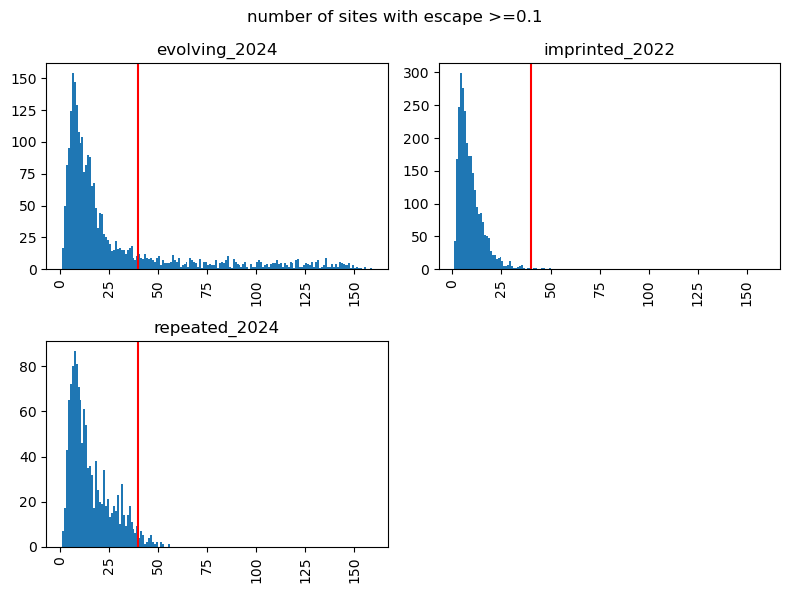

,antibody,site,escape,study
115,BD55-1041,453,0.081796,evolving_2024
119,BD55-1041,457,0.047790,evolving_2024
124,BD55-1041,462,1.000000,evolving_2024
128,BD55-1041,466,0.332554,evolving_2024
193,BD55-1205,331,0.055369,evolving_2024
...,...,...,...,...
500689,XGv-422,465,0.229740,imprinted_2022
500690,XGv-422,466,0.264641,imprinted_2022
500691,XGv-422,468,0.093587,imprinted_2022
500692,XGv-422,484,0.049302,imprinted_2022


Escape measurements for each study:


,n
study,
evolving_2024,134429
imprinted_2022,46301
repeated_2024,40229


In [19]:
escape = (
    pd.concat(
        [
            # get just antibodies from that study
            (
                escape_df
                .assign(
                    antibody=lambda x: x["antibody"].map(
                        lambda a: antibody_renaming[a] if a in antibody_renaming else a
                    ),
                )
                .merge(antibody_source.query("study == @study")[["antibody"]])
            )
            for study, escape_df in [
                ("evolving_2024", evolving_2024_escape),
                ("repeated_2024", repeated_2024_escape),
                ("imprinted_2022", imprinted_2022_escape),
            ]
        ],
        ignore_index=True,
    )
    .assign(
        escape=lambda x: (
            x["escape"] / x.groupby(["antibody", "study"])["escape"].transform("max")
        )
    )
)

assert len(escape) == len(escape.groupby(["antibody", "site"]))

# get and plot n sites with significant escape, then eliminate antibodies with
# too many sites of substantial escape
sig_escape_threshold = config["filter_antibodies"]["sig_escape_threshold"]
max_sig_sites = config["filter_antibodies"]["max_sig_sites"]
n_sig_escape = (
    escape
    .query("escape >= @sig_escape_threshold")
    .groupby(["antibody", "study"], as_index=False)
    .aggregate(n_sites=pd.NamedAgg("site", "nunique"))
)

ncols = 2
nrows = int(math.ceil(n_sig_escape["study"].nunique() / ncols))
axes = n_sig_escape.hist(
    column="n_sites",
    by="study",
    bins=range(1, n_sig_escape["n_sites"].max() + 1, 1),
    grid=False,
    layout=(nrows, ncols),
    figsize=(4 * ncols, 3 * nrows),
)
for ax in axes.ravel():
    ax.axvline(max_sig_sites, color="red")
fig = plt.gcf()
fig.suptitle(f"number of sites with escape >={sig_escape_threshold}")
fig.tight_layout()
plt.show(plt.gcf())

# drop antibodies with too many sites of escape
escape = (
    escape
    .merge(
        n_sig_escape.query("n_sites <= @max_sig_sites")[["antibody", "study"]],
        how="inner",
        validate="many_to_one",
    )
)

# drop low escape values
drop_escape_below = config["drop_escape_below"]
escape = escape.query("escape >= @drop_escape_below")
    
assert escape["antibody"].nunique() == len(escape.groupby(["antibody", "study"]))

display(escape)

print("Escape measurements for each study:")
display(escape.groupby("study").aggregate(n=pd.NamedAgg("site", "count")))

Only keep the antibodies that have all types of measurements when writing files in next cell:

In [20]:
antibodies = (
    antibody_source
    [["antibody"]]
    .assign(has_source=True)
    .drop_duplicates()
    .merge(
        antibody_ic50s[["antibody"]].assign(has_ic50=True).drop_duplicates(),
        how="outer",
        validate="one_to_one",
    )
    .merge(
        escape[["antibody"]].assign(has_escape=True).drop_duplicates(),
        how="outer",
        validate="one_to_one",
    )
    .set_index("antibody")
    .fillna(False)
    .assign(has_all=lambda x: x.all(axis=1))
    .reset_index()
)

print("This many antibodies have all measurements:")
display(
    antibodies
    .groupby([c for c in antibodies.columns if c != "antibody"])
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "count"))
)

antibodies_to_keep = set(antibodies.query("has_all")["antibody"])

This many antibodies have all measurements:


/tmp/ipykernel_72359/248179622.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


n_antibodies
has_source has_ic50 has_escape has_all              
False      True     False      False               4
True       False    False      False               2
           True     False      False            1130
                    True       True             6068

Get the antibody reweightings.
Unlike for other parameters, we only expect reweightings for some antibodies:

In [21]:
antibody_reweighting = repeated_2024_reweighting

antibody_reweighting

,antibody,study,reweight
0,CP0590,repeated_2024,1.246562
1,GC0101,repeated_2024,1.246562
2,GC0102,repeated_2024,1.246562
3,GC0103,repeated_2024,1.246562
4,GC0104,repeated_2024,1.246562
...,...,...,...
1198,GC2054,repeated_2024,1.477959
1199,GC2056,repeated_2024,1.477959
1200,GC2057,repeated_2024,1.477959
1201,GC2058,repeated_2024,0.874462


Write the output files, only with antibodies to keep:

In [22]:
os.makedirs("results", exist_ok=True)

(
    antibody_source
    .query("antibody in @antibodies_to_keep")
    .to_csv("results/antibody_sources.csv", index=False)
)

(
    antibody_ic50s
    .query("antibody in @antibodies_to_keep")
    .drop(columns="study")
    .to_csv("results/antibody_IC50s.csv", index=False)
)

(
    escape
    .query("antibody in @antibodies_to_keep")
    .drop(columns="study")
    .to_csv("results/escape.csv", float_format="%.4g", index=False)
)

(
    antibody_reweighting
    .query("antibody in @antibodies_to_keep")
    .drop(columns="study")
    .to_csv("results/antibody_reweighting.csv", float_format="%.4g", index=False)
)